# Modulation Classification

## Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize 
from scipy.integrate import cumtrapz
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
import keras.models as models
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Sequential
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D
import json
from keras.optimizers import Adam
from scipy import integrate


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
PATH = "/content/drive/MyDrive/Pattern Recognition/Modulation Classification"

## Dowload Dataset

In [4]:
%cp -av "/content/drive/MyDrive/Pattern Recognition/Modulation Classification/RML2016.10b.tar.bz2" "/content/dataset"

'/content/drive/MyDrive/Pattern Recognition/Modulation Classification/RML2016.10b.tar.bz2' -> '/content/dataset/RML2016.10b.tar.bz2'


In [5]:
!tar xjvf "/content/dataset/RML2016.10b.tar.bz2"

RML2016.10b.dat
LICENSE.TXT


In [ ]:
with open("/content/RML2016.10b.dat", 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()

In [3]:
file = open("/content/RML2016.10b.dat",'rb')
Xd = pickle.load(file, encoding = 'bytes')
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = [] 
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)
file.close()

## Visualization

In [7]:
def randomVisualization():
  mod = lbl[0][0]
  idx = []
  res = []
  idx.append([0, mod.decode("utf-8"), lbl[0][1]])
  for i in range(len(lbl)):
    if lbl[i][0] == mod:
      continue
    idx.append([i-1, mod.decode("utf-8"), lbl[i-1][1]])
    mod = lbl[i][0]
    idx.append([i, mod.decode("utf-8"), lbl[i][1]])
  idx.append([i-1, lbl[i-1][0].decode("utf-8"), lbl[i-1][1]])
  return idx

In [8]:
def plotFigures(idx):
  i = 0
  while i < len(idx):
    # plt.figure()
    # plt.title(str(id[1]) + " SNR = " + str(id[2]))
    # plt.plot(X[id[0]][0])
    # plt.plot(X[id[0]][1])

    fig, axs = plt.subplots(1,2, figsize=(20,5))
    axs[0].plot(X[idx[i][0]][0])
    axs[0].plot(X[idx[i][0]][1])
    axs[0].set_title(str(idx[i][1]) + ", SNR = " + str(idx[i][2]))
    axs[1].plot(X[idx[i+1][0]][0])
    axs[1].plot(X[idx[i+1][0]][1])
    axs[1].set_title(str(idx[i+1][1]) + ", SNR = " + str(idx[i+1][2]))
    i += 2


In [ ]:
X.shape

(1200000, 2, 128)

In [ ]:
idx = randomVisualization()
plotFigures(idx)

## Create Features

1. Raw time series as given (two channels)
2. First derivative in time (two channels)
3. Integral in time (two channels)
4. combinations of 1,2 and 3. (More channels)

In [ ]:
features = {}

In [ ]:
features['raw']        = X[:,0], X[:,1]

In [ ]:
features['derivative'] = normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))

In [ ]:
features['integral']   = normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))

In [ ]:
features['raw'][1].shape

(1200000, 128)

In [10]:
X = np.vstack(X)
X = np.asarray(X)
X = np.reshape(X, (1200000,256))

scaler = StandardScaler()
X = scaler.fit_transform(X)
lbl = np.asarray(lbl) 


In [11]:
X_deriv = []
for x in X:
  X_deriv.append(np.gradient(x))

X_int = []
for x in X:
  X_int.append(cumtrapz(x, initial=0))

# X_combined = []
# for x,x_d,x_i in zip(X,X_deriv,X_int):
#   X_combined.append(np.concatenate((x, x_d, x_i), axis=0))

In [12]:
X_deriv = np.asarray(X_deriv)

In [13]:
X_int = np.asarray(X_int)

In [ ]:
X_combined = np.asarray(X_combined)

In [4]:
y = np.array(lbl)

le = preprocessing.LabelEncoder()
le.fit(y[:,0])
y = le.transform(y[:,0])
y_new=[]
for i in range(len(y)):
  y_new.append([y[i],lbl[i][1]])

y=np.array(y_new)

In [108]:
np.unique(np.array(lbl)[:,0])

array([b'8PSK', b'AM-DSB', b'BPSK', b'CPFSK', b'GFSK', b'PAM4', b'QAM16',
       b'QAM64', b'QPSK', b'WBFM'], dtype='|S21')

In [5]:
lbls = np.unique(np.array(lbl)[:,0])
classes = []
for c in lbls: 
  classes.append(c.decode("utf-8"))

In [6]:
snrs = np.unique(np.array(lbl)[:,1])
lbl_snrs = []
for snr in snrs: 
  lbl_snrs.append(int(snr.decode("utf-8")))
lbl_snrs.sort()

In [7]:
X_int = []
for x in X:
  X_int.append(cumtrapz(x, initial=0))

X_int = np.asarray(X_int)


## Split Data

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X_int, y, train_size=0.7, test_size=0.3, stratify=lbl)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=19/20, test_size=1/20,stratify=y_train)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, stratify=lbl)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=19/20, test_size=1/20,stratify=y_train)

In [111]:
# x_train = x_train.reshape(x_train.shape[0],1,x_train.shape[1],x_train.shape[2])
# x_val = x_val.reshape(x_val.shape[0],1,x_val.shape[1],x_val.shape[2])
# x_test = x_test.reshape(x_test.shape[0],1,x_test.shape[1],x_test.shape[2])

In [68]:
print(x_train.shape[:])

(798000, 2, 128)


## CNN Model

### Functions

In [9]:
def save_model(myModel, myModel_history, name):
  myModel.save(PATH + "/MODEL_" + name + ".h5")
  with open(PATH + "/HISTORY_" + name + ".json", 'w') as f:
    json.dump(myModel_history.history, f)

In [9]:
def print_accuracies(test, train, val):
   print("Max Train accuracy = ", train)
   print("Max Val accuracy = ", val)
   print("Max Test accuracy = ", test)

In [10]:
def plot_evaluation(model_history):
  # plt.plot(model_history.history['accuracy'], label='accuracy')
  # plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
  # plt.xlabel('Epoch')
  # plt.ylabel('Accuracy')
  # plt.legend(loc='lower right')
  # plt.title("Train vs val accuracy")
  # plt.show()

  # plt.plot(model_history.history['loss'])
  # plt.plot(model_history.history['val_loss'])
  # plt.title('Model Loss')
  # plt.ylabel('Loss')
  # plt.xlabel('Epoch')
  # plt.legend(['train', 'val'], loc='upper left')
  # plt.show()
  fig, axs = plt.subplots(1,2, figsize=(20,5))
  axs[0].plot(model_history.history['accuracy'], label='accuracy')
  axs[0].plot(model_history.history['val_accuracy'], label = 'val_accuracy')
  axs[0].set_title("Train vs val accuracy")
  axs[0].set_xlabel('Epoch')
  axs[0].set_ylabel('Accuracy')
  axs[0].legend(loc='lower right')

  axs[1].plot(model_history.history['loss'])
  axs[1].plot(model_history.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_ylabel('Loss')
  axs[1].legend(['train', 'val'], loc='upper right')
  plt.show()


In [11]:
def plot_confusion_matrix(y_test, y_test_hat):
  cm = confusion_matrix(y_test[:,0], y_test_hat)
  # Plotting the confusion matrix
  plt.imshow(cm, cmap='Blues', aspect='auto')
  plt.colorbar()
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.xticks(np.arange(len(classes)), classes)
  plt.yticks(np.arange(len(classes)), classes)
  # Adding numbers to the cells
  for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          plt.text(j, i, cm[i, j], ha='center', va='center', color='black')
  plt.gcf().set_size_inches(10, 8)
  plt.show()

In [12]:
def plot_per_snr(y_test, y_test_hat):
  per_snr = []
  for snr in lbl_snrs:
    idx = np.where(y_test[:,1]==int(snr))
    acc = accuracy_score(y_test[idx][:,0], y_test_hat[idx])
    per_snr.append(acc)
  plt.plot(lbl_snrs, per_snr)
  plt.xlabel('SNR')
  plt.ylabel('Accuracy')
  plt.title('Accuracy per SNR')
  plt.show()

In [13]:
def evaluate_model(myModel, model_history):
  y_hat = myModel.predict(x_test)
  res = []
  for test in y_hat:
    res.append(np.argmax(test))
  res = np.array(res)
  plot_evaluation(model_history)
  plot_confusion_matrix(y_test, res)
  plot_per_snr(y_test, res)
  test_score = myModel.evaluate(x_test, y_test[:,0])
  return test_score[1], model_history.history['accuracy'][-1],model_history.history['val_accuracy'][-1]

### Model

In [59]:
import tensorflow as tf
def lr_decay(epoch):
    if epoch % 20 == 0:
        lr = tf.keras.backend.get_value(opt.lr)
        tf.keras.backend.set_value(opt.lr, lr*0.1)
        print("lr changed to {}".format(lr*0.1))
    return tf.keras.backend.get_value(opt.lr)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decay)

In [10]:
opt = Adam(lr=0.001)
# , decay=1e-6

CNNModel = keras.models.Sequential()
CNNModel.add(Reshape(list(x_train.shape[1:])+[1], input_shape=list(x_train.shape[1:])))
CNNModel.add(ZeroPadding2D((0, 2)))
CNNModel.add(Conv2D(64, (1, 3),padding='valid', activation="relu", name="conv1",kernel_initializer='glorot_uniform',data_format="channels_last"))
CNNModel.add(Dropout(0.3))
CNNModel.add(ZeroPadding2D((0, 2)))
CNNModel.add(Conv2D(16,(2, 3), padding='valid', activation="relu", name="conv2", kernel_initializer='glorot_uniform',data_format="channels_last"))
CNNModel.add(Dropout(0.3))
CNNModel.add(Flatten())
CNNModel.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
CNNModel.add(Dropout(0.3))
CNNModel.add(Dense( 10, kernel_initializer='he_normal', name="dense2" ))
CNNModel.add(Activation('softmax'))
CNNModel.add(Reshape([10]))
CNNModel.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
CNNModel.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 2, 128, 1)         0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 2, 132, 1)        0         
 2D)                                                             
                                                                 
 conv1 (Conv2D)              (None, 2, 130, 64)        256       
                                                                 
 dropout (Dropout)           (None, 2, 130, 64)        0         
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 2, 134, 64)       0         
 ng2D)                                                           
                                                                 
 conv2 (Conv2D)              (None, 1, 132, 16)        6

In [ ]:
history_cnn = CNNModel.fit(x_train,
    y_train[:,0],
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val[:,0]),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

Epoch 1/100
498/780 [==================>...........] - ETA: 5s - loss: 1.9489 - accuracy: 0.2346

In [47]:
save_model(CNNModel, history_cnn, "CNN_INT_0.001")

#### Tests

In [ ]:
## LR = 0.0001
history_cnn = CNNModel.fit(x_train,
    y_train[:,0],
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val[:,0]),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

Epoch 1/100
780/780 [==============================] - 25s 21ms/step - loss: 2.1486 - accuracy: 0.1634 - val_loss: 2.0626 - val_accuracy: 0.1825
Epoch 2/100
780/780 [==============================] - 16s 21ms/step - loss: 2.0307 - accuracy: 0.2042 - val_loss: 1.9650 - val_accuracy: 0.2407
Epoch 3/100
780/780 [==============================] - 16s 21ms/step - loss: 1.9322 - accuracy: 0.2410 - val_loss: 1.8441 - val_accuracy: 0.2773
Epoch 4/100
780/780 [==============================] - 16s 21ms/step - loss: 1.8393 - accuracy: 0.2661 - val_loss: 1.7570 - val_accuracy: 0.2991
Epoch 5/100
780/780 [==============================] - 17s 21ms/step - loss: 1.7818 - accuracy: 0.2863 - val_loss: 1.7038 - val_accuracy: 0.3249
Epoch 6/100
780/780 [==============================] - 16s 21ms/step - loss: 1.7341 - accuracy: 0.3096 - val_loss: 1.6483 - val_accuracy: 0.3576
Epoch 7/100
780/780 [==============================] - 17s 22ms/step - loss: 1.6798 - accuracy: 0.3355 - val_loss: 1.5893 - val_ac

In [ ]:
## Lr = 0.001 Decay=10-6
history_cnn = CNNModel.fit(x_train,
    y_train[:,0],
    batch_size=1024,
    epochs=100,
    verbose=1,
    validation_data=(x_val, y_val[:,0]),
    callbacks = [
         keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    ])

Epoch 1/100
780/780 [==============================] - 17s 21ms/step - loss: 1.9149 - accuracy: 0.2416 - val_loss: 1.6679 - val_accuracy: 0.3340
Epoch 2/100
780/780 [==============================] - 17s 22ms/step - loss: 1.5575 - accuracy: 0.3695 - val_loss: 1.3385 - val_accuracy: 0.4551
Epoch 3/100
780/780 [==============================] - 16s 21ms/step - loss: 1.3320 - accuracy: 0.4478 - val_loss: 1.2416 - val_accuracy: 0.4815
Epoch 4/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2736 - accuracy: 0.4678 - val_loss: 1.1750 - val_accuracy: 0.5028
Epoch 5/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2482 - accuracy: 0.4758 - val_loss: 1.1594 - val_accuracy: 0.5060
Epoch 6/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2328 - accuracy: 0.4804 - val_loss: 1.1495 - val_accuracy: 0.5060
Epoch 7/100
780/780 [==============================] - 16s 21ms/step - loss: 1.2220 - accuracy: 0.4841 - val_loss: 1.1765 - val_ac

### Evaluation

In [ ]:
plot_evaluation(history_cnn)

In [21]:
y_hat = CNNModel.predict(x_test)
res = []
for test in y_hat:
  res.append(np.argmax(test))
res = np.array(res)

11250/11250 [==============================] - 20s 2ms/step


In [ ]:
plot_confusion_matrix(y_test, res)

In [ ]:
plot_per_snr(y_test, res)

11250/11250 [==============================] - 20s 2ms/step


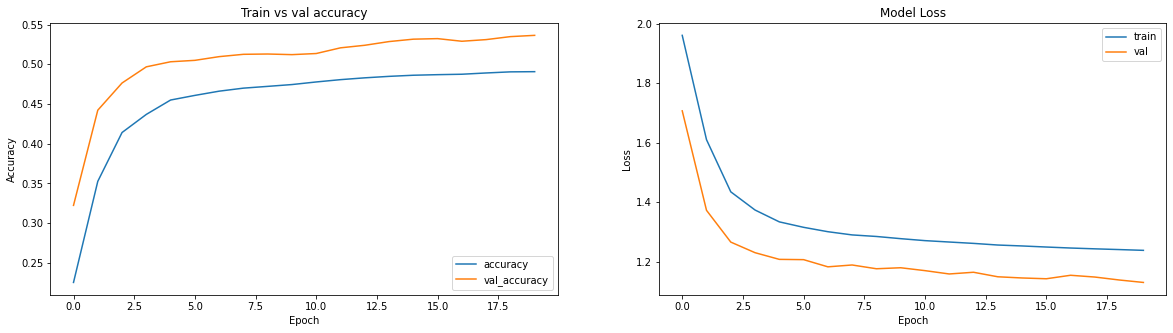

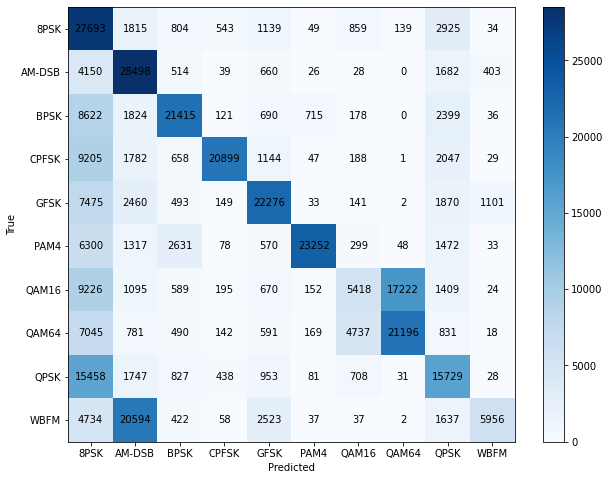

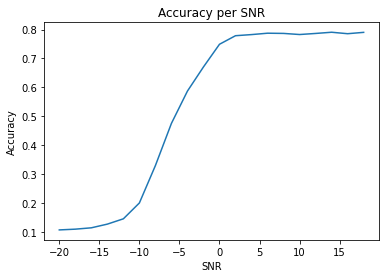

11250/11250 [==============================] - 30s 3ms/step - loss: 1.1331 - accuracy: 0.5343


In [55]:
test_acc, train_acc, val_acc = evaluate_model(CNNModel,history_cnn)

In [56]:
print_accuracies(test_acc, train_acc, val_acc)

Max Train accuracy =  0.4906177818775177
Max Val accuracy =  0.5363571643829346
Max Test accuracy =  0.5342555642127991


## Vanilla RNN Model

### Model

In [22]:
opt = Adam(lr=0.001, decay=1e-6)

RNNModel = Sequential()
RNNModel.add(SimpleRNN(128, input_shape=list(x_train.shape[1:]), activation='relu'))
RNNModel.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
RNNModel.add(Dropout(0.3))  # add dropout layer with rate 0.2
RNNModel.add(Dense(64, activation='relu'))
RNNModel.add(Dense(units=10, activation='softmax'))
RNNModel.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
RNNModel.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 128)               16512     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 10)                650       
                                                                 
Total params: 58,314
Trainable params: 58,314
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_rnn = RNNModel.fit(x_train, y_train[:,0], 
                           epochs=100, 
                           batch_size=1024, 
                           validation_data=(x_val, y_val[:,0]),
                           verbose=1, 
                           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/100
780/780 [==============================] - 5s 6ms/step - loss: 1.8005 - accuracy: 0.2810 - val_loss: 1.5835 - val_accuracy: 0.3531
Epoch 2/100
780/780 [==============================] - 4s 6ms/step - loss: 1.5556 - accuracy: 0.3601 - val_loss: 1.5041 - val_accuracy: 0.3822
Epoch 3/100
780/780 [==============================] - 4s 5ms/step - loss: 1.4994 - accuracy: 0.3811 - val_loss: 1.4646 - val_accuracy: 0.3937
Epoch 4/100
780/780 [==============================] - 4s 5ms/step - loss: 1.4661 - accuracy: 0.3920 - val_loss: 1.4362 - val_accuracy: 0.4049
Epoch 5/100
780/780 [==============================] - 4s 6ms/step - loss: 1.4387 - accuracy: 0.4007 - val_loss: 1.4117 - val_accuracy: 0.4058
Epoch 6/100
780/780 [==============================] - 4s 5ms/step - loss: 1.4137 - accuracy: 0.4064 - val_loss: 1.3849 - val_accuracy: 0.4127
Epoch 7/100
780/780 [==============================] - 4s 5ms/step - loss: 1.3915 - accuracy: 0.4134 - val_loss: 1.3677 - val_accuracy: 0.4220

In [24]:
save_model(RNNModel, history_rnn, "RNN_RAW_0.001+DECAY*10-6")

#### Tests

In [ ]:
history_rnn = RNNModel.fit(x_train, y_train[:,0], 
                           epochs=100, 
                           batch_size=1024, 
                           validation_data=(x_val, y_val[:,0]),
                           verbose=1, 
                           callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/100
780/780 [==============================] - 6s 7ms/step - loss: 1.7918 - accuracy: 0.2818 - val_loss: 1.5718 - val_accuracy: 0.3549
Epoch 2/100
780/780 [==============================] - 5s 7ms/step - loss: 1.5463 - accuracy: 0.3634 - val_loss: 1.4907 - val_accuracy: 0.3820
Epoch 3/100
780/780 [==============================] - 6s 7ms/step - loss: 1.4895 - accuracy: 0.3838 - val_loss: 1.4589 - val_accuracy: 0.3909
Epoch 4/100
780/780 [==============================] - 7s 9ms/step - loss: 1.4549 - accuracy: 0.3950 - val_loss: 1.4214 - val_accuracy: 0.4070
Epoch 5/100
780/780 [==============================] - 5s 6ms/step - loss: 1.4266 - accuracy: 0.4049 - val_loss: 1.4095 - val_accuracy: 0.4137
Epoch 6/100
780/780 [==============================] - 4s 6ms/step - loss: 1.4030 - accuracy: 0.4117 - val_loss: 1.3734 - val_accuracy: 0.4210
Epoch 7/100
780/780 [==============================] - 5s 7ms/step - loss: 1.3778 - accuracy: 0.4198 - val_loss: 1.3539 - val_accuracy: 0.4277

### Evaluation

11250/11250 [==============================] - 25s 2ms/step


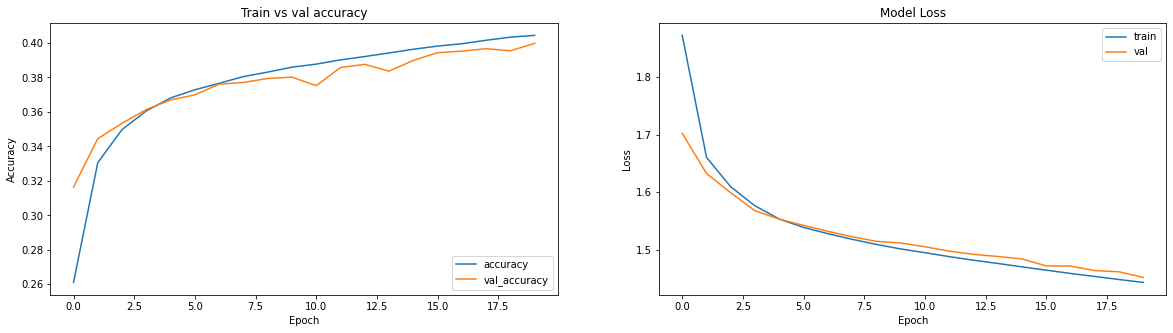

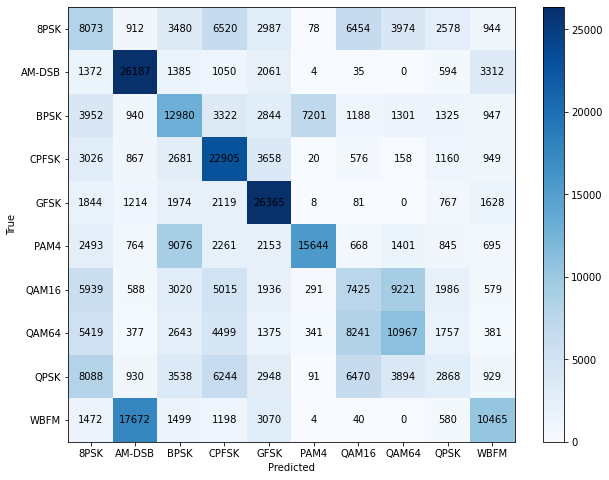

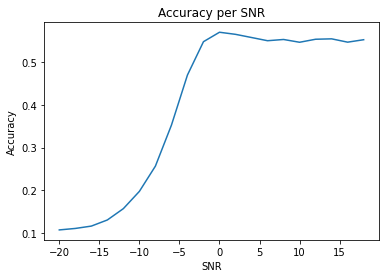

11250/11250 [==============================] - 30s 3ms/step - loss: 1.4496 - accuracy: 0.3997


In [50]:
test_acc, train_acc, val_acc = evaluate_model(RNNModel,history_rnn)

In [51]:
print_accuracies(test_acc, train_acc, val_acc)

Max Train accuracy =  0.404364675283432
Max Val accuracy =  0.3997381031513214
Max Test accuracy =  0.39966389536857605


## LSTM Model

### Model

In [25]:
opt = Adam(lr=0.001, decay=1e-6)
# , decay=1e-6

LSTMModel = Sequential()
LSTMModel.add(LSTM(128, dropout = 0.3, return_sequences = True, recurrent_dropout = 0.3, input_shape = list(x_train.shape[1:])))
LSTMModel.add(Flatten())
LSTMModel.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
LSTMModel.add(Dense(10, activation = 'softmax'))
LSTMModel.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
LSTMModel.summary()

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2, 128)            131584    
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               32896     
                                                                 
 dense_22 (Dense)            (None, 10)                1290      
                                                                 
Total params: 165,770
Trainable params: 165,770
Non-trainable params: 0
_________________________________________________________________


In [26]:
history_lstm = LSTMModel.fit(x_train, y_train[:,0], 
                                 epochs=100, batch_size=1024, 
                                 validation_data=(x_val, y_val[:,0]),
                                 verbose=1, 
                                 callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])


Epoch 1/100
780/780 [==============================] - 15s 16ms/step - loss: 2.0691 - accuracy: 0.1968 - val_loss: 2.0087 - val_accuracy: 0.2184
Epoch 2/100
780/780 [==============================] - 14s 18ms/step - loss: 2.0151 - accuracy: 0.2161 - val_loss: 1.9955 - val_accuracy: 0.2250
Epoch 3/100
780/780 [==============================] - 10s 13ms/step - loss: 1.9981 - accuracy: 0.2238 - val_loss: 1.9623 - val_accuracy: 0.2403
Epoch 4/100
780/780 [==============================] - 10s 13ms/step - loss: 1.9643 - accuracy: 0.2401 - val_loss: 1.9319 - val_accuracy: 0.2522
Epoch 5/100
780/780 [==============================] - 10s 13ms/step - loss: 1.9391 - accuracy: 0.2482 - val_loss: 1.9071 - val_accuracy: 0.2585
Epoch 6/100
780/780 [==============================] - 10s 13ms/step - loss: 1.9156 - accuracy: 0.2548 - val_loss: 1.8822 - val_accuracy: 0.2636
Epoch 7/100
780/780 [==============================] - 10s 13ms/step - loss: 1.8864 - accuracy: 0.2638 - val_loss: 1.8460 - val_ac

In [24]:
test = keras.models.load_model(PATH + "/model_LSTM_RAW.h5")

In [28]:
with open(PATH +'/history_LSTM_RAW.json', 'r') as f:
    history_test = json.load(f)

In [27]:
save_model(LSTMModel, history_lstm, "LSTM_RAW_0.001+DECAY*10-6")

### Evaluation

11250/11250 [==============================] - 29s 3ms/step


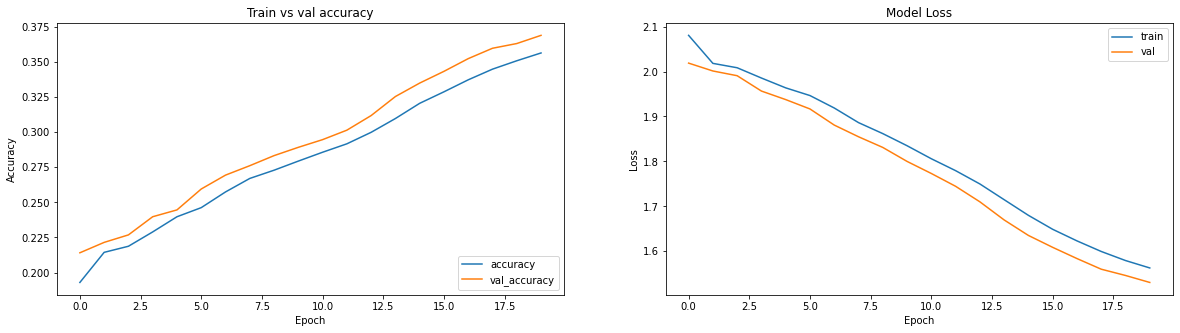

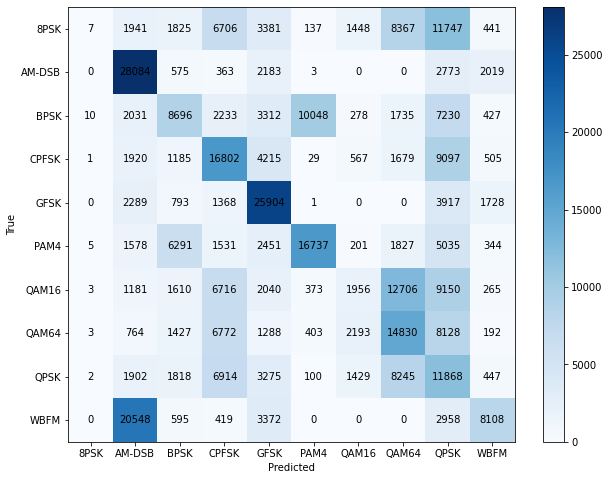

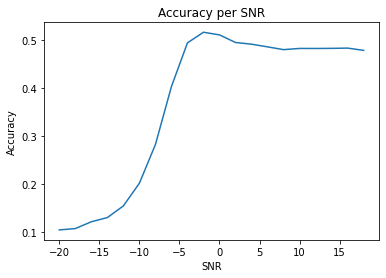

11250/11250 [==============================] - 34s 3ms/step - loss: 1.5291 - accuracy: 0.3694


In [16]:
test_acc, train_acc, val_acc = evaluate_model(LSTMModel,history_lstm)

In [17]:
print_accuracies(test_acc, train_acc, val_acc)

Max Train accuracy =  0.35637718439102173
Max Val accuracy =  0.3689047694206238
Max Test accuracy =  0.36942222714424133
